In [5]:
import os # For directory operation
import pandas as pd # data analysis
import pydicom as dicom
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [4]:
data_dir="D:FYP/Data Sets/stage1"
patients=os.listdir(data_dir)

patients_labels=pd.read_csv('D:FYP/Data Sets/Labels/stage1_labels.csv',index_col=0)
print("Number of Patients:  ",len(patients))
print("Patient Having Cancer\n",patients_labels.cancer.value_counts())
print("Labels of patients:",patients_labels.head())


Number of Patients:   1595
Patient Having Cancer
 0    1176
1     419
Name: cancer, dtype: int64
Labels of patients:                                   cancer
id                                      
0015ceb851d7251b8f399e39779d1e7d       1
0030a160d58723ff36d73f41b170ec21       0
003f41c78e6acfa92430a057ac0b306e       0
006b96310a37b36cccb2ab48d10b49a3       1
008464bb8521d09a42985dd8add3d0d2       1


C:\Users\aliza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


1
MONOCHROME2


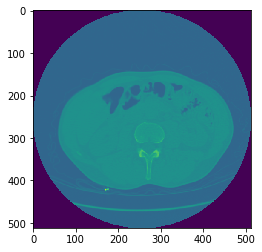

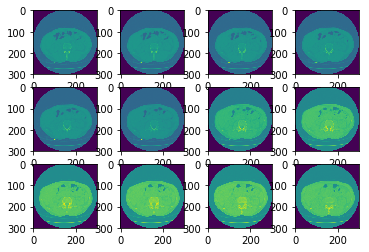

In [94]:
MAX_IMG_SIZE=300

for patient in patients[:1]:
    single_label=patients_labels.get_value(patient,"cancer")
    single_patient_dir=data_dir +'/'+ patient

    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    print(slices[0].SamplesPerPixel)
    print(slices[100].PhotometricInterpretation)
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    plt.imshow(slices[0].pixel_array)
#     see multiple slices of a patient
    fig=plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y=fig.add_subplot(3,4,num+1)
        new_image=cv2.resize(np.array(each_slice.pixel_array),(MAX_IMG_SIZE,MAX_IMG_SIZE))
        y.imshow(new_image)

#         y.imshow(new_image,cmap='gray')
#     plt.show()

In [135]:
import math
MAX_IMG_SIZE=50
MAX_SLICES_PER_PATIENT=20

def chunks(l, n):
#     """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def mean(l):
    return sum(l) / len(l)

def process_data(index,patient,patients_labels,max_image_size=50,max_slices_per_patient=20,visualize=False):
    single_label=patients_labels.get_value(patient,"cancer")
    single_patient_dir=data_dir +'/'+ patient
    slices = [dicom.read_file(single_patient_dir + '/' + s) for s in os.listdir(single_patient_dir)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    new_slices=[]
    
    slices=[cv2.resize(np.array(each_slice.pixel_array),(MAX_IMG_SIZE,MAX_IMG_SIZE)) for each_slice in slices]
    
    chunk_sizes=math.ceil(len(slices)/MAX_SLICES_PER_PATIENT)
    if single_label==1:single_label=np.array([0,1])
    elif single_label==0:single_label=np.array([1,0])

    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk=list(map(mean,zip(*slice_chunk)))
        new_slices.append([np.array(slice_chunk),single_label])


    if len(new_slices) == MAX_SLICES_PER_PATIENT-1:
        new_slices.append([np.array(new_slices[-1]),single_label])

    if len(new_slices) == MAX_SLICES_PER_PATIENT-2:
        new_slices.append([np.array(new_slices[-1]),single_label])
        new_slices.append([np.array(new_slices[-1]),single_label])

    if len(new_slices) == MAX_SLICES_PER_PATIENT+2:
        new_val = list(map(mean, zip(*[new_slices[MAX_SLICES_PER_PATIENT-1],new_slices[MAX_SLICES_PER_PATIENT],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == MAX_SLICES_PER_PATIENT+1:
        new_val = list(map(mean, zip(*[new_slices[MAX_SLICES_PER_PATIENT-1],new_slices[MAX_SLICES_PER_PATIENT],])))
        del new_slices[MAX_SLICES_PER_PATIENT]
        new_slices[MAX_SLICES_PER_PATIENT-1] = new_val

    print(index,"Each Patient Slice: ",len(new_slices),single_label,single_patient_dir)
    
    if visualize:
        fig=plt.figure()
        for num,each_slice in enumerate(new_slices):
            y=fig.add_subplot(4,5,num+1)
            y.imshow(each_slice,cmap='gray')
        plt.show()
        
    
      
    return new_slices

preprocessed_data=[]
# data_dir="D:FYP/Data Sets/stage1"
# patients=os.listdir(data_dir)
# patients_labels=pd.read_csv('D:FYP/Data Sets/Labels/stage1_labels.csv',index_col=0)

for num,patient in enumerate(patients[:2]):
    if(num%100==0):
        print(num)
    try:
        image_data=process_data(num+1,patient, patients_labels , max_image_size=MAX_IMG_SIZE , max_slices_per_patient=MAX_IMG_SIZE , visualize=False )
        preprocessed_data.append(image_data)
    except keyError as e:
        print("This is imlabeled data")
np.save('Labeled-slices--{}--{}--{}.npy'.format(MAX_IMG_SIZE,MAX_IMG_SIZE,MAX_SLICES_PER_PATIENT),preprocessed_data)

0


C:\Users\aliza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


1 Each Patient Slice:  20 [0 1] D:FYP/Data Sets/stage1/0015ceb851d7251b8f399e39779d1e7d
2 Each Patient Slice:  20 [1 0] D:FYP/Data Sets/stage1/0030a160d58723ff36d73f41b170ec21


In [9]:
much_data = np.load('Labeled-slices--50--50--20.npy',allow_pickle=True)
print(much_data[0][0][0][0])
# for i in much_data:
#     print(i[1])

[-2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.
 -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.
 -2000.  -2000.     26.5    16.3    23.6    25.9    22.6    15.5    34.5
    40.5    29.1    16.6 -2000.  -2000.  -2000.  -2000.  -2000.  -2000.
 -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.  -2000.
 -2000.  -2000.  -2000.  -2000.  -2000. ]
